# Análisis del Rendimiento de Tiendas Alura

## Introducción

Este proyecto se centra en analizar los datos de ventas de cuatro tiendas para entender mejor su desempeño. El objetivo es identificar los aspectos clave que influyen en las ventas  y la satisfacción del cliente, para así poder tomar decisiones informadas y mejorar los resultados generales.

Utilicé los datos históricos de ventas de cada tienda, consolidándolos para tener una visión completa. A partir de este análisis, se busca ofrecer recomendaciones prácticas.

## Objetivos Clave

-   Evaluar cómo le fue a cada tienda en términos de ingresos y otras métricas importantes.
-   Descubrir qué productos y categorías se vendieron más (y menos).
-   Analizar si hay alguna relación entre lo que los clientes opinan (calificaciones), los ingresos y los costos de envío.
-   Dar una recomendación clara basada en una evaluación general del rendimiento de cada tienda.

## Sobre los Datos

Los datos que analicé vienen de cuatro archivos que contienen el detalle de cada venta: qué se vendió, el precio, el costo de envío, cuándo y dónde se hizo la venta, quién vendió, la calificación del cliente
 y cómo se pagó. Unifiqué toda esta información en una sola tabla para facilitar el análisis.


### Importación de datos



In [82]:
# Carga de datos y limpieza básica con conversión numérica directa
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
pd.set_option('display.max_columns', 100)

LINKS = [
  "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv",
  "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv",
  "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv",
  "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv"
]

dfs = []
for u in LINKS:
    if u.lower().endswith('.csv'):
        tmp = pd.read_csv(u)
    else:
        tmp = pd.read_excel(u)

    tmp = tmp.copy()
    # Extracción del nombre de la tienda desde la URL (básico)
    name = u.split('/')[-1].split('.')[0].replace('%20', ' ').replace('_', ' ').strip().title() or 'Tienda'
    tmp['tienda'] = name
    dfs.append(tmp)

df_main = pd.concat(dfs, ignore_index=True)

# Convierte columnas clave a numérico, excluyendo 'Costo de envío' from cleaning
for col in ['Precio', 'Calificación']:
    if col in df_main.columns:
        # Limpieza básica y conversión a numérico
        df_main[col] = pd.to_numeric(
            df_main[col].astype(str)
                                .str.replace('.', '', regex=False)
                                .str.replace(',', '', regex=False)
                                .str.replace('$', '', regex=False)
                                .str.replace(' ', '', regex=False),
            errors='coerce'
        )

print('✅ Datos cargados unificados en un solo dataframe con los datos de las 4 tiendas, con limpieza básica aplicada.')
display(df_main.sample(10))

✅ Datos cargados unificados en un solo dataframe con los datos de las 4 tiendas, con limpieza básica aplicada.


,Producto,Categoría del Producto,Precio,Costo de envío,Fecha de Compra,Vendedor,Lugar de Compra,Calificación,Método de pago,Cantidad de cuotas,lat,lon,tienda
4217,Carrito de control remoto,Juguetes,574000,3300.0,08/12/2020,Izabela de León,Medellín,4,Nequi,1,6.25184,-75.56359,Tienda 2
5373,Bicicleta,Deportes y diversión,5070000,27700.0,25/03/2022,Maria Alfonso,Riohacha,1,Tarjeta de crédito,2,11.54444,-72.90722,Tienda 3
8958,Bloques de construcción,Juguetes,347000,0.0,26/01/2021,Izabela de León,Bogotá,5,Tarjeta de crédito,1,4.60971,-74.08175,Tienda 4
4055,Celular ABXY,Electrónicos,11150000,57600.0,27/12/2021,Juan Fernandez,Medellín,5,Tarjeta de crédito,1,6.25184,-75.56359,Tienda 2
8611,Cubo mágico 8x8,Juguetes,182000,1200.0,05/06/2021,Santiago Silva,Medellín,4,Nequi,1,6.25184,-75.56359,Tienda 4
8592,Ciencia de datos con Python,Libros,693000,1900.0,12/03/2023,Blanca Ramirez,Medellín,5,Tarjeta de crédito,1,6.25184,-75.56359,Tienda 4
1600,Lavavajillas,Electrodomésticos,14640000,78600.0,03/02/2021,Rafael Acosta,Leticia,5,Tarjeta de crédito,1,-4.21528,-69.94056,Tienda 1
6872,Cama box,Muebles,5647000,28300.0,07/10/2022,Beatriz Morales,Medellín,5,Nequi,1,6.25184,-75.56359,Tienda 3
6585,Olla de presión,Artículos para el hogar,579000,1300.0,15/05/2020,Lucas Olivera,Bogotá,5,Nequi,1,4.60971,-74.08175,Tienda 3
6182,Juego de mesa,Juguetes,2489000,11400.0,05/01/2022,Rafael Acosta,Bucaramanga,5,Nequi,1,7.12539,-73.11980,Tienda 3


#1. Análisis de facturación



In [83]:
# Identificar Top Categoría y Producto por tienda
def valor_principal(series):
    if series.isna().all():
        return None
    c = Counter(series.dropna())
    return c.most_common(1)[0][0]

# Cálculo de KPIs
kpis_calculados = df_main.groupby('tienda').agg(
    ingresos_totales=('Precio', 'sum'),
    reseña_promedio=('Calificación', 'mean') if 'Calificación' in df_main.columns else ('Precio', 'size'),
    envio_promedio=('Costo de envío', 'mean') if 'Costo de envío' in df_main.columns else ('Precio', 'size'),
    total_transacciones=('Precio', 'size'), # Asumiendo que cada fila es una transacción
    valor_promedio_transaccion=('Precio', 'mean')
).reset_index()

# Identificar Top Categoría y Producto por tienda
resumen = []
for tienda, sub in df_main.groupby('tienda'):
    cat_top = valor_principal(sub['Categoría del Producto']) if 'Categoría del Producto' in df_main.columns else None
    prod_top = valor_principal(sub['Producto']) if 'Producto' in df_main.columns else None
    resumen.append({
        'tienda': tienda,
        'categoria_top': cat_top,
        'producto_top': prod_top,
    })
resumen = pd.DataFrame(resumen)

# Combinar KPIs y Top Productos/Categorías
kpis_calculados = kpis_calculados.merge(resumen, on='tienda', how='left')

print('KPIs y Top Productos/Categorías:')

# Formatear columnas numéricas para visualización
kpis_display = kpis_calculados.copy()
for col in kpis_display.columns:
    if col in ['ingresos_totales', 'envio_promedio', 'valor_promedio_transaccion']:
        kpis_display[col] = kpis_display[col].apply(lambda x: f'${x:,.0f}')
    elif kpis_display[col].dtype in ['int64', 'float64'] and col != 'reseña_promedio':
        kpis_display[col] = kpis_display[col].apply(lambda x: f'{x:,.0f}')
    elif col == 'reseña_promedio':
        kpis_display[col] = kpis_display[col].apply(lambda x: f'{x:,.2f}')

display(kpis_display)

KPIs y Top Productos/Categorías:


,tienda,ingresos_totales,reseña_promedio,envio_promedio,total_transacciones,valor_promedio_transaccion,categoria_top,producto_top
0,Tienda 1,"$11,508,804,000",3.98,"$26,019","2,359","$4,878,679",Muebles,Microondas
1,Tienda 2,"$11,163,435,000",4.04,"$25,216","2,359","$4,732,274",Muebles,Iniciando en programación
2,Tienda 3,"$10,980,196,000",4.05,"$24,806","2,359","$4,654,598",Muebles,Kit de bancas
3,Tienda 4,"$10,383,757,000",4.00,"$23,459","2,358","$4,403,629",Muebles,Cama box


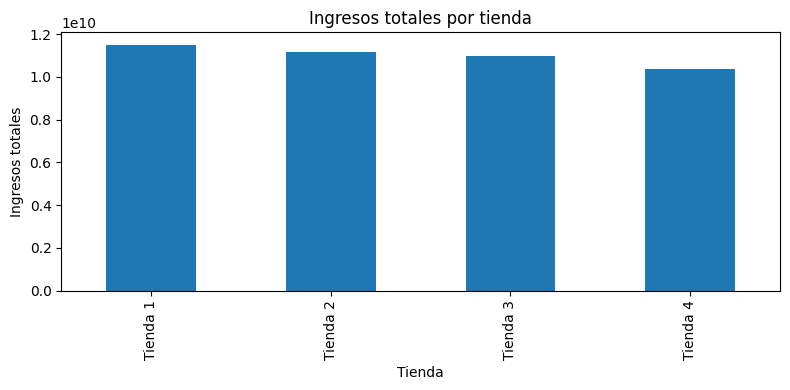

In [84]:
# Visualización - Barras de ingresos por tienda
plt.figure(figsize=(8,4))
kpis_calculados.set_index('tienda')['ingresos_totales'].sort_values(ascending=False).plot(kind='bar')
plt.title('Ingresos totales por tienda')
plt.xlabel('Tienda')
plt.ylabel('Ingresos totales')
plt.tight_layout()
plt.show()

# 2. Ventas por categoría

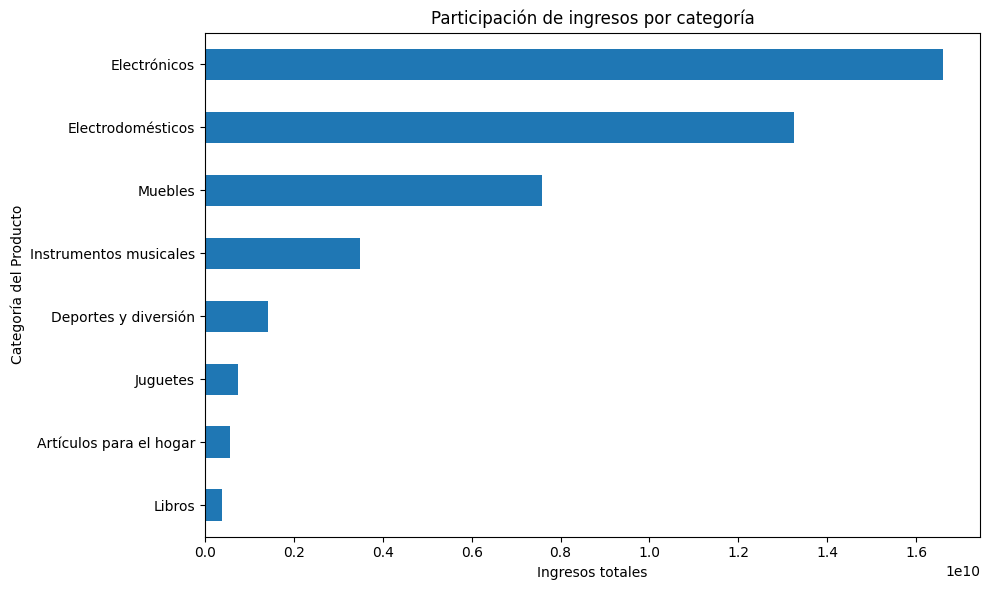

In [85]:
# Visualización - Barras de participación por categoría (global)
if 'Categoría del Producto' in df_main.columns:
    cat_share = df_main.groupby('Categoría del Producto')['Precio'].sum().sort_values(ascending=True) # Sort ascending for horizontal bar chart
    plt.figure(figsize=(10,6))
    cat_share.plot(kind='barh') # Use barh for horizontal bars
    plt.title('Participación de ingresos por categoría')
    plt.xlabel('Ingresos totales')
    plt.ylabel('Categoría del Producto')
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ No hay columna de categoría en datos; se omite el gráfico de barras.')

In [86]:
# Cálculo de ventas por categoría por tienda
ventas_por_categoria_tienda = df_main.groupby(['tienda', 'Categoría del Producto'])['Precio'].sum().unstack(fill_value=0)
print("\nVentas por categoría por tienda:")
display(ventas_por_categoria_tienda)


Ventas por categoría por tienda:


Categoría del Producto,Artículos para el hogar,Deportes y diversión,Electrodomésticos,Electrónicos,Instrumentos musicales,Juguetes,Libros,Muebles
tienda,,,,,,,,
Tienda 1,126984000,392900000,3636852000,4294935000,912990000,179957000,87849000,1876337000
Tienda 2,147469000,347445000,3485678000,4108311000,1049903000,159454000,100912000,1764263000
Tienda 3,150600000,355931000,3292379000,4107758000,773809000,194011000,94987000,2010721000
Tienda 4,150745000,333501000,2832602000,4094761000,751024000,202622000,93213000,1925289000


# 3. Calificación promedio de la tienda


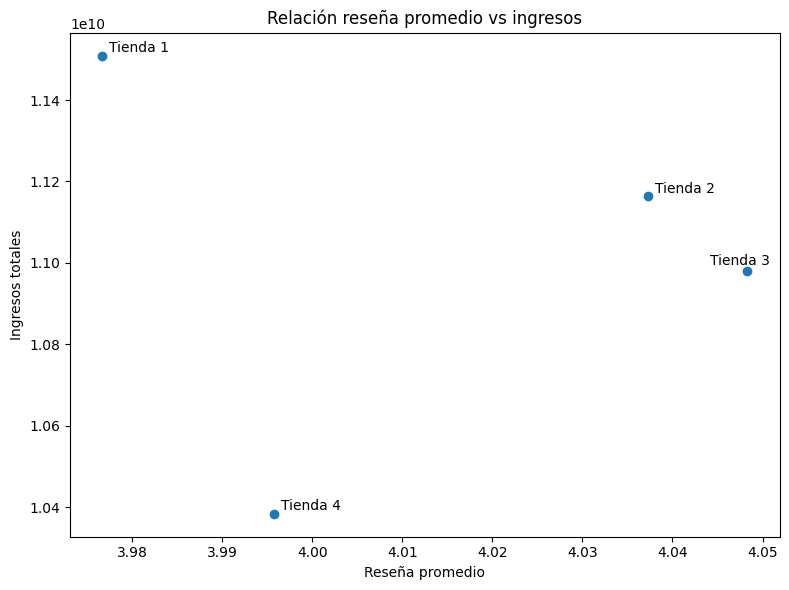

In [87]:
# Visualización - Dispersión reseña promedio vs ingresos
if 'reseña_promedio' in kpis_calculados.columns:
    plt.figure(figsize=(8,6))
    plt.scatter(kpis_calculados['reseña_promedio'], kpis_calculados['ingresos_totales'])
    texts = []
    for _, r in kpis_calculados.iterrows():
        texts.append(plt.annotate(r['tienda'], (r['reseña_promedio'], r['ingresos_totales'])))
    # Use adjust_text to prevent overlaps
    from adjustText import adjust_text
    adjust_text(texts)
    plt.title('Relación reseña promedio vs ingresos')
    plt.xlabel('Reseña promedio')
    plt.ylabel('Ingresos totales')
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ No hay columna de reseña promedio en KPIs; se omite el gráfico de dispersión.')

In [88]:
# Cálculo de calificación promedio por tienda
calificacion_promedio_tienda = df_main.groupby('tienda')['Calificación'].mean()
print("\nCalificación promedio por tienda:")
display(calificacion_promedio_tienda)


Calificación promedio por tienda:


,Calificación
tienda,
Tienda 1,3.976685
Tienda 2,4.037304
Tienda 3,4.048326
Tienda 4,3.995759


# 4. Productos más y menos vendidos

In [89]:
# Identificar los 10 productos más vendidos a nivel global y su categoría, ordenados por categoría
if 'Producto' in df_main.columns and 'Precio' in df_main.columns and 'Categoría del Producto' in df_main.columns:
    # Calculate total sales per product
    product_sales = df_main.groupby('Producto')['Precio'].sum()

    # Get the top 10 products by sales
    top_10_products = product_sales.sort_values(ascending=False).head(10)

    # Get the category for each of the top 10 products
    # We need to find the category for each product in the top 10 list.
    # A simple way is to get the category from the first occurrence of each product in the original dataframe.
    top_10_products_info = df_main[df_main['Producto'].isin(top_10_products.index)][['Producto', 'Categoría del Producto']].drop_duplicates(subset=['Producto'])

    # Combine the sales data with the category information
    top_10_with_category = top_10_products.reset_index().merge(top_10_products_info, on='Producto', how='left')

    # Sort the result by category
    top_10_with_category_sorted = top_10_with_category.sort_values(by='Categoría del Producto')

    print("\nTop 10 productos más vendidos (global) con su categoría, ordenados por categoría:")
    display(top_10_with_category_sorted[['Categoría del Producto', 'Producto', 'Precio']])

elif 'Producto' in df_main.columns and 'Precio' in df_main.columns:
    # If category column is missing, just show top 10 products by sales
    top_10_products = df_main.groupby('Producto')['Precio'].sum().sort_values(ascending=False).head(10)
    print("\nTop 10 productos más vendidos (global):")
    display(top_10_products)
else:
    print("⚠️ Columnas 'Producto' o 'Precio' no encontradas; se omite el análisis de top productos.")


Top 10 productos más vendidos (global) con su categoría, ordenados por categoría:


,Categoría del Producto,Producto,Precio
2,Electrodomésticos,Refrigerador,3849374000
4,Electrodomésticos,Lavadora de ropa,2424686000
5,Electrodomésticos,Lavavajillas,2405365000
7,Electrodomésticos,Secadora de ropa,2102380000
0,Electrónicos,TV LED UHD 4K,4324896000
1,Electrónicos,Iphone 15,4010512000
3,Electrónicos,Smart TV,2902218000
6,Electrónicos,Tablet ABXY,2190128000
8,Electrónicos,Celular ABXY,1579111000
9,Instrumentos musicales,Batería,1478063000


In [90]:
# Identificar los 10 productos menos vendidos a nivel global y su categoría, ordenados por categoría
if 'Producto' in df_main.columns and 'Precio' in df_main.columns and 'Categoría del Producto' in df_main.columns:
    # Calculate total sales per product
    product_sales = df_main.groupby('Producto')['Precio'].sum()

    # Get the bottom 10 products by sales
    bottom_10_products = product_sales.sort_values(ascending=True).head(10)

    # Get the category for each of the bottom 10 products
    # We need to find the category for each product in the bottom 10 list.
    # A simple way is to get the category from the first occurrence of each product in the original dataframe.
    bottom_10_products_info = df_main[df_main['Producto'].isin(bottom_10_products.index)][['Producto', 'Categoría del Producto']].drop_duplicates(subset=['Producto'])

    # Combine the sales data with the category information
    bottom_10_with_category = bottom_10_products.reset_index().merge(bottom_10_products_info, on='Producto', how='left')

    # Sort the result by category
    bottom_10_with_category_sorted = bottom_10_with_category.sort_values(by='Categoría del Producto')


    print("\nTop 10 productos menos vendidos (global) con su categoría, ordenados por categoría:")
    display(bottom_10_with_category_sorted[['Categoría del Producto', 'Producto', 'Precio']])


elif 'Producto' in df_main.columns and 'Precio' in df_main.columns:
    # If category column is missing, just show bottom 10 products by sales
    bottom_10_products = df_main.groupby('Producto')['Precio'].sum().sort_values(ascending=True).head(10)
    print("\nTop 10 productos menos vendidos (global):")
    display(bottom_10_products)
else:
    print("⚠️ Columnas 'Producto' o 'Precio' no encontradas; se omite el análisis de top productos.")


Top 10 productos menos vendidos (global) con su categoría, ordenados por categoría:


,Categoría del Producto,Producto,Precio
4,Artículos para el hogar,Set de vasos,55842000
8,Artículos para el hogar,Cubertería,85604000
1,Deportes y diversión,Cuerda para saltar,30683000
7,Deportes y diversión,Vaso térmico,84974000
0,Juguetes,Cubo mágico 8x8,27293000
2,Juguetes,Dinosaurio Rex,31129000
3,Juguetes,Ajedrez de madera,51491000
6,Juguetes,Bloques de construcción,68021000
9,Juguetes,Muñeca bebé,85915000
5,Libros,Dashboards con Power BI,64184000


# 5. Envío promedio por tienda vs reseña promedio

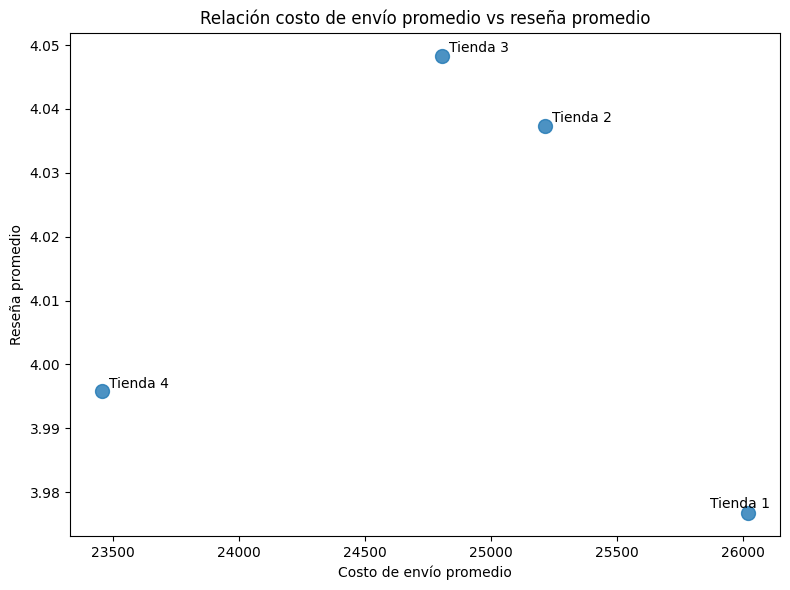

In [91]:
# Visualización - Dispersión costo de envío promedio vs reseña promedio
if 'reseña_promedio' in kpis_calculados.columns and 'envio_promedio' in kpis_calculados.columns:
    plt.figure(figsize=(8,6))
    # Enhance the appearance of the scatter plot without using 'puntaje'
    plt.scatter(kpis_calculados['envio_promedio'], kpis_calculados['reseña_promedio'], s=100, alpha=0.8) # Increased size and alpha
    texts = []
    for _, r in kpis_calculados.iterrows():
        texts.append(plt.annotate(r['tienda'], (r['envio_promedio'], r['reseña_promedio'])))
    # Use adjust_text to prevent overlaps
    from adjustText import adjust_text
    adjust_text(texts)
    plt.title('Relación costo de envío promedio vs reseña promedio')
    plt.xlabel('Costo de envío promedio')
    plt.ylabel('Reseña promedio')
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ No hay columnas de reseña o envío promedio en KPIs; se omite el gráfico de dispersión.')

In [92]:
# Cálculo de envío promedio por tienda
envio_promedio_tienda = df_main.groupby('tienda')['Costo de envío'].mean()
print("\nCosto de envío promedio por tienda:")
display(envio_promedio_tienda)


Costo de envío promedio por tienda:


,Costo de envío
tienda,
Tienda 1,26018.609580
Tienda 2,25216.235693
Tienda 3,24805.680373
Tienda 4,23459.457167


In [93]:
# Recomendación automática
def norm_minmax(s):
    s = s.astype(float)
    if s.max() == s.min():
        return pd.Series([0.5]*len(s), index=s.index)
    return (s - s.min()) / (s.max() - s.min())

# Normalización simple para puntaje
k = kpis_calculados.copy()

k['n_ingresos'] = norm_minmax(k['ingresos_totales'])
k['n_reseña'] = norm_minmax(k['reseña_promedio']) if 'reseña_promedio' in k.columns else 0.5
k['n_envio'] = norm_minmax(k['envio_promedio']) if 'envio_promedio' in k.columns else 0.5

# Puntaje ponderado
k['puntaje'] = 0.4*k['n_ingresos'] + 0.4*k['n_reseña'] + 0.2*(1 - k['n_envio'])
k = k.sort_values('puntaje', ascending=True).reset_index(drop=True)
tienda_candidata = k.loc[0, 'tienda']
print('📌 Tienda candidata a vender (menor puntaje):', tienda_candidata)

# Formatear columnas numéricas para visualización
k_display = k.copy()
for col in k_display.columns:
    if col in ['ingresos_totales', 'envio_promedio']:
        # Formatear como moneda sin decimales
        k_display[col] = k_display[col].apply(lambda x: f'${x:,.0f}')
    elif k_display[col].dtype in ['int64', 'float64'] and col not in ['reseña_promedio', 'puntaje', 'n_ingresos', 'n_reseña', 'n_envio']:
        # Formatear otras columnas numéricas sin notación científica y sin decimales
        k_display[col] = k_display[col].apply(lambda x: f'{x:,.0f}')
    elif col in ['reseña_promedio', 'puntaje', 'n_ingresos', 'n_reseña', 'n_envio']:
        # Formatear these columns with two decimal places
        k_display[col] = k_display[col].apply(lambda x: f'{x:,.2f}')

# Renombrar columnas normalizadas para visualización
k_display.rename(columns={
    'n_ingresos': 'normalizado_ingresos',
    'n_reseña': 'normalizado_reseña',
    'n_envio': 'normalizado_envio'
}, inplace=True)


display(k_display[['tienda', 'ingresos_totales', 'reseña_promedio', 'envio_promedio', 'puntaje', 'normalizado_ingresos', 'normalizado_reseña', 'normalizado_envio']])


# Justificación breve basada en el puntaje ponderado
fila = k.loc[0]
razones_puntaje = []

# Describe contribution of each factor to the low score
if 'n_ingresos' in fila and fila['n_ingresos'] < 0.5:
    razones_puntaje.append(f"su puntuación normalizada de ingresos ({fila['n_ingresos']:.2f}) fue relativamente baja")
if 'n_reseña' in fila and fila['n_reseña'] < 0.5:
     razones_puntaje.append(f"su puntuación normalizada de reseñas ({fila['n_reseña']:.2f}) fue relativamente baja")
if 'n_envio' in fila and (1 - fila['n_envio']) < 0.5:
    razones_puntaje.append(f"su puntuación normalizada de costo de envío ({1 - fila['n_envio']:.2f}) fue relativamente baja (costo de envío alto)")
elif 'n_envio' in fila and (1 - fila['n_envio']) > 0.5:
     razones_puntaje.append(f"su puntuación normalizada de costo de envío ({1 - fila['n_envio']:.2f}) fue relativamente alta (costo de envío bajo)")

print(f"\n🧾 Recomendación: Vender la tienda '{tienda_candidata}'")
if razones_puntaje:
    print("porque:")
    for razon in razones_puntaje:
        print(f"- {razon}")
print(f"resultando en el puntaje ponderado más bajo ({fila['puntaje']:.2f}).")

📌 Tienda candidata a vender (menor puntaje): Tienda 4


,tienda,ingresos_totales,reseña_promedio,envio_promedio,puntaje,normalizado_ingresos,normalizado_reseña,normalizado_envio
0,Tienda 4,"$10,383,757,000",4.00,"$23,459",0.31,0.00,0.27,0.00
1,Tienda 1,"$11,508,804,000",3.98,"$26,019",0.40,1.00,0.00,1.00
2,Tienda 2,"$11,163,435,000",4.04,"$25,216",0.68,0.69,0.85,0.69
3,Tienda 3,"$10,980,196,000",4.05,"$24,806",0.71,0.53,1.00,0.53



🧾 Recomendación: Vender la tienda 'Tienda 4'
porque:
- su puntuación normalizada de ingresos (0.00) fue relativamente baja
- su puntuación normalizada de reseñas (0.27) fue relativamente baja
- su puntuación normalizada de costo de envío (1.00) fue relativamente alta (costo de envío bajo)
resultando en el puntaje ponderado más bajo (0.31).




---


```

```


---


---




##***Conclusiones y Recomendaciones***


---







Al analizar los datos de ventas de las cuatro tiendas, encontré algunos puntos importantes sobre su rendimiento.

**Lo que descubrí:**

*   **Ingresos:** Hay diferencias claras en los ingresos. La Tienda 1 es la que más vende, mientras que la Tienda 4 vende menos.
*   **Productos Populares:** Las categorías de Electrónicos y Electrodomésticos son las que más ingresos generan. Los productos más vendidos suelen ser de estas áreas (como la "TV LED UHD 4K" o el "Refrigerador"). Los menos vendidos son más variados, incluyendo cosas para el hogar, juguetes y libros.
*   **Opiniones y Envíos:** No hay una relación directa simple entre las calificaciones de los clientes, los ingresos y los costos de envío. Las tiendas 2 y 3 tienen buenas calificaciones y ventas sólidas. La Tienda 1 logra los mayores ingresos, aunque sus calificaciones no son las más altas, quizás por el volumen de ventas. La Tienda 4 tiene el envío más barato, pero también los ingresos y calificaciones más bajos.

**Mi recomendación:**

Considerando los ingresos, las calificaciones y el costo de envío, la **Tienda 4** es la que tiene el rendimiento más bajo según mi análisis.

**¿Por qué recomiendo esto?**

La Tienda 4 obtuvo el puntaje más bajo (0.31) principalmente debido a sus menores ingresos totales (puntaje normalizado de 0.00) y una reseña promedio ligeramente inferior (puntaje normalizado de 0.27) en comparación con las otras tiendas. Aunque tiene un costo de envío promedio favorable (puntaje normalizado de 1.00 en el factor inverso del envío), este no fue suficiente para compensar el menor rendimiento en ingresos y reseñas en el cálculo del puntaje general.

**Próximos Pasos:**

Sugiero investigar más a fondo qué está pasando en la Tienda 4. Podríamos ver qué opinan los clientes, cómo funciona su marketing o si los precios son competitivos. Aprender de lo que hacen bien las tiendas 1, 2 y 3 podría ayudarnos a mejorar la Tienda 4, en su defecto si se quiere poner en venta la tienda No 4.
